In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import networkx as nx
import pandas as pd
import numpy as np
#import matplotlib
#matplotlib.use('Agg')
import matplotlib
import matplotlib.pylab as plt
from matplotlib.pyplot import cm
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
import datetime
import geopandas as gpd
from warnings import filterwarnings
import os
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats import kendalltau
from geopy import distance
import collections
from itertools import product

In [3]:
import ipystata
from ipystata.config import config_stata
config_stata('/home/ubuntu/stata/stata-mp')  

IPyStata is loaded in batch mode.


In [4]:
##############################################
# DATAPREP from non-aggregated data
# see pd.read_csv below instead
##############################################

# import pyproj

# p1 = pyproj.Proj('epsg:4326')
# p2 = pyproj.Proj('epsg:23700')

# t = pyproj.Transformer.from_proj(p1,p2)

# def latLonToCartesian(args):
#     return t.transform(*args)

# # Hungarian cities connected to iwiw's city id (CityId) with some metadata
# cities = pd.read_csv('../iwiw_data/cities_final.csv')
# cities['CoordinateLatLon'] = list(zip(cities.Latitude, cities.Longitude))
# cities['CoordinateXY'] = list(map(latLonToCartesian, list(zip(cities.Latitude, cities.Longitude))))
# cities["PopLog"] = cities["PopLog"]*np.log(10)


# # user dataframe
# df_orig = pd.read_csv('../iwiw_data/UsersWithNumOfConnections_Cleaned.csv', sep = '\t')
# # selecting relecant columns
# df_orig = df_orig[['Id', 'InvitorId', 'RegistrationDate', 'LastLoginDate', 'CountryId', 'CityId', 
#                    'NumOfConnections', 'BirthYear']]
# # parsing adoption and churn dates
# df_orig['RegistrationDate'] =  pd.to_datetime(df_orig['RegistrationDate'], format='%Y-%m-%d')
# df_orig['LastLoginDate'] =  pd.to_datetime(df_orig['LastLoginDate'], format='%Y-%m-%d')
# len_orig = len(df_orig)

# # keep only the users with:
#     # more than 0 connections --> This might be pointless to filter, 
#                                  # since if everyone has at least one connection,
#                                  # its invitor. If its invitor deleted itself, then the line is dropped
#                                  # anyways by the InvitorId criteria
#     # has less than 5000 connections --> people with this much connection are probably spam account creators
#     # its real invitor id is known
#     # used iWiW at least for a day
# # length df_orig: 4.576.664
# print('Original data length: {}\n'.format(len_orig))
# df_filtered = df_orig[(df_orig['NumOfConnections'] > 0) &
#                 (df_orig['NumOfConnections'] < 5000) &
#                 (df_orig['InvitorId'] != 100000000.0) &
#                 (df_orig['RegistrationDate'] != df_orig['LastLoginDate'])].dropna(subset = ['InvitorId']).drop_duplicates(subset = ['Id'])
# len_necessary_filters = len(df_filtered)
# print('Length after necessary filters: {}'.format(len_necessary_filters))
# print('{} users lost in this step'.format(len_orig-len_necessary_filters))
# print('{} users lost in total\n'.format(len_orig-len_necessary_filters))

# # Filter users who are not in Hungary, the resulting dataframe has 3.704.879 records
# df_filtered['InvitorId'] = df_filtered['InvitorId'].map(int)
# df_filtered=df_filtered[df_filtered['CountryId'] == 110]
# len_non_hungary = len(df_filtered)
# print('Length after dropping users outside Hungary: {}'.format(len_non_hungary))
# print('{} users lost in this step'.format(len_necessary_filters-len_non_hungary))
# print('{} users lost in total\n'.format(len_orig-len_non_hungary))

# # 2685 unique CityId after mapping (min CityId = 10, max CityId = 138163)
# # 2555 unique CityId in the file provided by Balázs (min CityId = 379, max CityId = 138163)
# # There are 19 records with CityId < 379
# df_filtered['CityId'] = df_filtered['CityId'].map(int)


# # there are 23484 Users who are with correct Country Id, but Incorrect CityId
# df_filtered = df_filtered[df_filtered['CityId'].isin(cities['CityId'])]
# len_non_cityId = len(df_filtered)
# print('Length after dropping unknown Hungarian CityIds: {}'.format(len_non_cityId))
# print('{} users lost in this step'.format(len_non_hungary-len_non_cityId))
# print('{} users lost in total\n'.format(len_orig-len_non_cityId))


# # Checked. No records are lost during merge --> Only correct CityIds in the filtered df
# df_filtered = df_filtered.merge(cities[['CityId','CityName', 'CoordinateXY', 'PopLog']])

# # Insert the year of registration
# df_filtered['RegYear'] = df_filtered['RegistrationDate'].dt.year
# df_filtered['RegByMonth'] = df_filtered['RegistrationDate'].dt.to_period('M')
# df_filtered['RegByQ'] = df_filtered['RegistrationDate'].dt.to_period('Q')

# # ID mappings
# id_to_city = dict(df_filtered[['Id', 'CityId']].values)
# id_to_invitorId = dict(df_filtered[['Id', 'InvitorId']].values)
# id_to_name = dict(cities[['CityId', 'CityName']].values)

# # Keeping only those invitors who are present as users too
# invitorId_to_cityId = dict(zip(df_filtered[df_filtered['Id'].isin(df_filtered['InvitorId'].unique())]['Id'],
#                                df_filtered[df_filtered['Id'].isin(df_filtered['InvitorId'].unique())]['CityId']))
# cityId_to_poplog  = dict(df_filtered[['CityId', 'PopLog']].values)
# cityId_to_coordinate = dict(df_filtered[['CityId', 'CoordinateXY']].values)

# # Run the actual mappings
# df_filtered.insert(6, 'InvitorCityId', df_filtered['InvitorId'].map(invitorId_to_cityId))
# df_filtered = df_filtered.dropna(subset = ['InvitorCityId'])
# len_no_invCityId = len(df_filtered)
# print('Length after dropping users with unknown InvitorCityIds: {}'.format(len_no_invCityId))
# print('{} users lost in this step'.format(len_non_cityId-len_no_invCityId))
# print('{} users lost in total\n'.format(len_orig-len_no_invCityId))


# df_filtered['InvitorCityId'] = pd.to_numeric(df_filtered['InvitorCityId'], downcast = 'integer')
# df_filtered.insert(9, 'InvitorPopLog', df_filtered['InvitorCityId'].map(cityId_to_poplog))
# df_filtered['InvitorCoordinateXY'] = df_filtered['InvitorCityId'].map(cityId_to_coordinate)
# df_filtered['InvitorCityName'] = df_filtered['InvitorCityId'].map(id_to_name)



# # Creating population bins
# bw = df_filtered['PopLog'].max()/30
# df_filtered['Bin'] = df_filtered['PopLog'].map(lambda x: int(x/bw))
# df_filtered['InvitorBin'] = df_filtered['InvitorPopLog'].map(lambda x: int(x/bw))


# # Re-bin the dataset to remove the 'gaps' between bins. The best would be to use the poplog boundaries as binIDs
# # TODO: implement this
# origBin_to_goodBin = dict(zip(sorted(df_filtered['Bin'].unique(), reverse = True), 
#                               np.linspace(len(df_filtered['Bin'].unique()), 1, len(df_filtered['Bin'].unique()))))
# df_filtered['Bin'] = pd.to_numeric(df_filtered['Bin'].map(origBin_to_goodBin), downcast = 'integer')
# df_filtered['InvitorBin'] = pd.to_numeric(df_filtered['InvitorBin'].map(origBin_to_goodBin), downcast='integer')

# len(set(df_filtered["Id"].unique()).union(set(df_filtered["InvitorId"].unique())))

# len(set(df_filtered["CityId"].unique()).union(set(df_filtered["InvitorCityId"].unique())))

# def calcDist(a, b):
#     a = np.array(a)
#     b = np.array(b)
#     return np.linalg.norm(a-b)/1000

# df_filtered['Distance'] = np.vectorize(calcDist)(df_filtered['CoordinateXY'], df_filtered['InvitorCoordinateXY'])

# from itertools import product

# for i,j in product(range(5),range(5)):
#     if i!=j:
#         print(cities.loc[i]["CityName"],cities.loc[j]["CityName"],calcDist(cities.loc[i]["CoordinateXY"],cities.loc[j]["CoordinateXY"])/1000)

# temp = df_filtered.groupby(["RegYear","CityId","InvitorCityId"])[["Id"]].count().reset_index().rename({"Id":"w"},axis=1)

# full_edgelist = pd.DataFrame(product(cities.CityId,cities.CityId),columns = ["CityId","InvitorCityId"])
# full_edgelist = full_edgelist[full_edgelist["CityId"]!=full_edgelist["InvitorCityId"]]
# full_edgelist["CoordinateXY"] = full_edgelist["CityId"].map(cities.set_index("CityId")["CoordinateXY"].to_dict())
# full_edgelist["InvitorCoordinateXY"] = full_edgelist["InvitorCityId"].map(cities.set_index("CityId")["CoordinateXY"].to_dict())
# full_edgelist['log_d_ij'] = np.log(np.vectorize(calcDist)(full_edgelist['CoordinateXY'], full_edgelist['InvitorCoordinateXY']))
# full_edgelist.drop(["CoordinateXY","InvitorCoordinateXY"],axis=1,inplace=True)
# full_edgelist["log_P_j"] = full_edgelist["CityId"].map(cities.set_index("CityId")["PopLog"].to_dict())
# full_edgelist["log_P_i"] = full_edgelist["InvitorCityId"].map(cities.set_index("CityId")["PopLog"].to_dict())

# full_edgelist["log_P_i_2"] = full_edgelist["log_P_i"]**2
# full_edgelist["log_P_j_2"] = full_edgelist["log_P_j"]**2
# full_edgelist["log_P_i_log_P_j"] = full_edgelist["log_P_i"]*full_edgelist["log_P_j"]

In [6]:
full_edgelist = pd.read_csv('../iwiw_data/full_edgelist_for_regression.csv.gz',header=0,index_col=None)

In [17]:
full_edgelist.head()

,CityId,InvitorCityId,log_d_ij,log_P_j,log_P_i,log_P_i_2,log_P_j_2,log_P_i_log_P_j
1,379,380,5.271786,14.36942,12.243340,149.899374,206.480243,175.929700
2,379,381,4.992562,14.36942,12.024689,144.593141,206.480243,172.787809
3,379,382,5.087712,14.36942,12.043860,145.054567,206.480243,173.063290
4,379,383,5.134707,14.36942,11.962733,143.106985,206.480243,171.897542
5,379,384,4.680256,14.36942,11.787249,138.939228,206.480243,169.375930


In [18]:
def subset_edgelist(year, nonzero = False):
    full_edgelist_subset = pd.merge(full_edgelist,temp[temp["RegYear"]==year][["CityId","InvitorCityId","w"]],how="left").fillna(0).rename({"w":"w_ij"},axis=1)
    full_edgelist_subset["sum_w_ij"] = full_edgelist_subset["InvitorCityId"].map(full_edgelist_subset.groupby(["InvitorCityId"])["w_ij"].sum().to_dict())
    full_edgelist_subset.drop(["CityId","InvitorCityId"],axis=1,inplace=True)
    full_edgelist_subset = full_edgelist_subset[~np.isinf(full_edgelist_subset.log_d_ij)]
    
    if nonzero:
        return full_edgelist_subset[full_edgelist_subset["w_ij"]>0]
    return full_edgelist_subset

In [19]:
full_edgelist_subset = subset_edgelist(2002)

In [25]:
%%stata -d full_edgelist_subset
zinb w_ij log_d_ij log_P_i log_P_j log_P_i_2 log_P_j_2 log_P_i_log_P_j, inflate(log_d_ij log_P_i log_P_j log_P_i_2 log_P_j_2 log_P_i_log_P_j) iter(100)
est store zinb1
esttab zinb1 using model_2002_new.txt, tab replace se star(* 0.10 ** 0.05 *** 0.01)


Fitting constant-only model:

Iteration 0:   log likelihood = -12402.092  (not concave)
Iteration 1:   log likelihood = -6842.0129  (not concave)
Iteration 2:   log likelihood = -5937.4709  (not concave)
Iteration 3:   log likelihood = -5348.9885  (not concave)
Iteration 4:   log likelihood =   -5029.32  
Iteration 5:   log likelihood = -3034.3934  
Iteration 6:   log likelihood =  -2901.455  
Iteration 7:   log likelihood = -2852.6418  
Iteration 8:   log likelihood = -2850.6392  
Iteration 9:   log likelihood = -2850.6321  
Iteration 10:  log likelihood = -2850.6321  

Fitting full model:

Iteration 0:   log likelihood = -2850.6321  (not concave)
Iteration 1:   log likelihood = -2782.3149  
Iteration 2:   log likelihood = -2583.8997  
Iteration 3:   log likelihood =  -2516.078  
Iteration 4:   log likelihood = -2496.4294  
Iteration 5:   log likelihood = -2490.2885  
Iteration 6:   log likelihood = -2489.4147  
Iteration 7:   log likelihood =   -2488.88  
Iteration 8:   log likeliho

In [26]:
full_edgelist_subset = subset_edgelist(2003)

In [27]:
%%stata -d full_edgelist_subset
zinb w_ij log_d_ij log_P_i log_P_j log_P_i_2 log_P_j_2 log_P_i_log_P_j, inflate(log_d_ij log_P_i log_P_j log_P_i_2 log_P_j_2 log_P_i_log_P_j) iter(100)
est store zinb1
esttab zinb1 using model_2003_new.txt, tab replace se star(* 0.10 ** 0.05 *** 0.01)


Fitting constant-only model:

Iteration 0:   log likelihood =  -26706.56  (not concave)
Iteration 1:   log likelihood =  -12269.32  (not concave)
Iteration 2:   log likelihood = -11359.035  (not concave)
Iteration 3:   log likelihood = -10581.316  
Iteration 4:   log likelihood = -6287.4692  
Iteration 5:   log likelihood = -6060.3526  
Iteration 6:   log likelihood = -6028.6107  
Iteration 7:   log likelihood = -6027.7106  
Iteration 8:   log likelihood = -6027.7072  
Iteration 9:   log likelihood = -6027.7072  

Fitting full model:

Iteration 0:   log likelihood = -6027.7072  (not concave)
Iteration 1:   log likelihood = -5843.7816  (not concave)
Iteration 2:   log likelihood = -5673.0384  
Iteration 3:   log likelihood = -5281.3569  
Iteration 4:   log likelihood = -5154.0189  
Iteration 5:   log likelihood = -5127.0818  
Iteration 6:   log likelihood = -5120.2516  
Iteration 7:   log likelihood = -5118.9962  
Iteration 8:   log likelihood = -5118.8032  
Iteration 9:   log likeliho

In [28]:
full_edgelist_subset = subset_edgelist(2004)

In [ ]:
%%stata -d full_edgelist_subset
zinb w_ij log_d_ij log_P_i log_P_j log_P_i_2 log_P_j_2 log_P_i_log_P_j, inflate(log_d_ij log_P_i log_P_j log_P_i_2 log_P_j_2 log_P_i_log_P_j) iter(100)
est store zinb1
esttab zinb1 using model_2004_new.txt, tab replace se star(* 0.10 ** 0.05 *** 0.01)


Fitting constant-only model:

Iteration 0:   log likelihood = -42828.623  (not concave)
Iteration 1:   log likelihood = -19436.672  (not concave)
Iteration 2:   log likelihood = -18189.604  (not concave)
Iteration 3:   log likelihood = -16882.566  
Iteration 4:   log likelihood = -11597.961  (not concave)
Iteration 5:   log likelihood = -10544.944  
Iteration 6:   log likelihood = -10273.515  
Iteration 7:   log likelihood = -10263.346  
Iteration 8:   log likelihood =   -10263.3  
Iteration 9:   log likelihood =   -10263.3  

Fitting full model:

Iteration 0:   log likelihood =   -10263.3  (not concave)
Iteration 1:   log likelihood = -9978.6081  (not concave)
Iteration 2:   log likelihood = -9671.8089  
Iteration 3:   log likelihood = -9170.7867  
Iteration 4:   log likelihood = -8843.6017  
Iteration 5:   log likelihood = -8764.1743  
Iteration 6:   log likelihood = -8758.3452  
Iteration 7:   log likelihood = -8758.1393  
Iteration 8:   log likelihood = -8758.1371  
Iteration 9:  

In [ ]:
full_edgelist_subset = subset_edgelist(2005)

In [ ]:
%%stata -d full_edgelist_subset
zinb w_ij log_d_ij log_P_i log_P_j log_P_i_2 log_P_j_2 log_P_i_log_P_j, inflate(log_d_ij log_P_i log_P_j log_P_i_2 log_P_j_2 log_P_i_log_P_j) iter(100)
est store zinb1
esttab zinb1 using model_2005_new.txt, tab replace se star(* 0.10 ** 0.05 *** 0.01)


Fitting constant-only model:

Iteration 0:   log likelihood = -232673.22  (not concave)
Iteration 1:   log likelihood = -99262.744  (not concave)
Iteration 2:   log likelihood = -83751.653  
Iteration 3:   log likelihood = -56558.099  
Iteration 4:   log likelihood = -54518.848  
Iteration 5:   log likelihood = -54167.779  
Iteration 6:   log likelihood = -54166.067  
Iteration 7:   log likelihood = -54166.067  

Fitting full model:

Iteration 0:   log likelihood = -54166.067  (not concave)
Iteration 1:   log likelihood = -51781.058  (not concave)
Iteration 2:   log likelihood = -50305.541  
Iteration 3:   log likelihood = -46359.075  
Iteration 4:   log likelihood = -44927.046  
Iteration 5:   log likelihood = -44464.676  
Iteration 6:   log likelihood = -44376.736  
Iteration 7:   log likelihood = -44359.991  
Iteration 8:   log likelihood = -44359.781  
Iteration 9:   log likelihood =  -44359.78  

Zero-inflated negative binomial regression      Number of obs     =  6,525,466
     

In [ ]:
full_edgelist_subset = subset_edgelist(2006)

In [ ]:
%%stata -d full_edgelist_subset
zinb w_ij log_d_ij log_P_i log_P_j log_P_i_2 log_P_j_2 log_P_i_log_P_j, inflate(log_d_ij log_P_i log_P_j log_P_i_2 log_P_j_2 log_P_i_log_P_j) iter(100)
est store zinb1
esttab zinb1 using model_2006_new.txt, tab replace se star(* 0.10 ** 0.05 *** 0.01)


Fitting constant-only model:

Iteration 0:   log likelihood =   -1017382  (not concave)
Iteration 1:   log likelihood = -470743.53  (not concave)
Iteration 2:   log likelihood = -402035.11  
Iteration 3:   log likelihood = -289551.87  
Iteration 4:   log likelihood = -268832.77  
Iteration 5:   log likelihood = -267740.68  
Iteration 6:   log likelihood = -267704.78  
Iteration 7:   log likelihood = -267704.69  
Iteration 8:   log likelihood = -267704.69  

Fitting full model:

Iteration 0:   log likelihood = -267704.69  (not concave)
Iteration 1:   log likelihood = -248105.55  (not concave)
Iteration 2:   log likelihood =  -235152.1  
Iteration 3:   log likelihood = -219384.77  
Iteration 4:   log likelihood = -216354.34  
Iteration 5:   log likelihood = -216016.02  
Iteration 6:   log likelihood = -215977.32  
Iteration 7:   log likelihood = -215976.37  
Iteration 8:   log likelihood = -215976.37  

Zero-inflated negative binomial regression      Number of obs     =  6,525,466
     

In [ ]:
import numpy as np

In [ ]:
full_edgelist_subset = subset_edgelist(2007)

In [ ]:
%%stata -d full_edgelist_subset
zinb w_ij log_d_ij log_P_i log_P_j log_P_i_2 log_P_j_2 log_P_i_log_P_j, inflate(log_d_ij log_P_i log_P_j log_P_i_2 log_P_j_2 log_P_i_log_P_j) iter(100)
est store zinb1
esttab zinb1 using model_2007_new.txt, tab replace se star(* 0.10 ** 0.05 *** 0.01)

In [ ]:
full_edgelist_subset = subset_edgelist(2008)

In [ ]:
%%stata -d full_edgelist_subset
zinb w_ij log_d_ij log_P_i log_P_j log_P_i_2 log_P_j_2 log_P_i_log_P_j, inflate(log_d_ij log_P_i log_P_j log_P_i_2 log_P_j_2 log_P_i_log_P_j) iter(100)
est store zinb1
esttab zinb1 using model_2008_new.txt, tab replace se star(* 0.10 ** 0.05 *** 0.01)

In [ ]:
full_edgelist_subset = subset_edgelist(2009)

In [ ]:
%%stata -d full_edgelist_subset
zinb w_ij log_d_ij log_P_i log_P_j log_P_i_2 log_P_j_2 log_P_i_log_P_j, inflate(log_d_ij log_P_i log_P_j log_P_i_2 log_P_j_2 log_P_i_log_P_j) iter(100)
est store zinb1
esttab zinb1 using model_2009_new.txt, tab replace se star(* 0.10 ** 0.05 *** 0.01)

In [ ]:
full_edgelist_subset = subset_edgelist(2010)

In [ ]:
%%stata -d full_edgelist_subset
zinb w_ij log_d_ij log_P_i log_P_j log_P_i_2 log_P_j_2 log_P_i_log_P_j, inflate(log_d_ij log_P_i log_P_j log_P_i_2 log_P_j_2 log_P_i_log_P_j) iter(100)
est store zinb1
esttab zinb1 using model_2010_new.txt, tab replace se star(* 0.10 ** 0.05 *** 0.01)

In [ ]:
full_edgelist_subset = subset_edgelist(2011)

In [ ]:
%%stata -d full_edgelist_subset
zinb w_ij log_d_ij log_P_i log_P_j log_P_i_2 log_P_j_2 log_P_i_log_P_j, inflate(log_d_ij log_P_i log_P_j log_P_i_2 log_P_j_2 log_P_i_log_P_j) iter(100)
est store zinb1
esttab zinb1 using model_2011_new.txt, tab replace se star(* 0.10 ** 0.05 *** 0.01)

In [ ]:
full_edgelist_subset = subset_edgelist(2012)

In [ ]:
%%stata -d full_edgelist_subset
zinb w_ij log_d_ij log_P_i log_P_j log_P_i_2 log_P_j_2 log_P_i_log_P_j, inflate(log_d_ij log_P_i log_P_j log_P_i_2 log_P_j_2 log_P_i_log_P_j) iter(100)
est store zinb1
esttab zinb1 using model_2012_new.txt, tab replace se star(* 0.10 ** 0.05 *** 0.01)

In [20]:
def parse_stata(year, mode = ""):
    if mode == "":
        num_vars = 3
    elif mode == "_b":
        num_vars = 4
    elif mode == "_c":
        num_vars = 5
    elif mode == "_new":
        num_vars = 6
        
    df = pd.read_csv('model_' + str(year) + mode + '.txt',sep="\t",skiprows = 3, skipfooter=3,header=None)
    
    res = []
    res.append(["model_part","variable","value","std_error","significance", "year"])
    
    for i in range(1,(num_vars+1)*2+1,2):
        val = df.iloc[i,1]
        stars = 0
        newval = ""
        for s in str(val):
            if s=="*":
                stars+=1
            else:
                newval+=s
        res.append(["model_w_ij",df.iloc[i,0],float(newval),float(df.iloc[i+1,1].replace("(","").replace(")","")),stars, year])
        
    for i in range((num_vars+2)*2,(num_vars+2)*2+(num_vars+1)*2,2):
        val = df.iloc[i,1]
        stars = 0
        newval = ""
        for s in str(val):
            if s=="*":
                stars+=1
            else:
                newval+=s
        res.append(["model_inflate",df.iloc[i,0],float(newval),float(df.iloc[i+1,1].replace("(","").replace(")","")),stars, year])
        
    for i in range((num_vars+2)*2+(num_vars+1)*2+1,(num_vars+2)*2+(num_vars+1)*2+3,2):
        val = df.iloc[i,1]
        stars = 0
        newval = ""
        for s in str(val):
            if s=="*":
                stars+=1
            else:
                newval+=s
        res.append(["model_general",df.iloc[i,0],float(newval),float(df.iloc[i+1,1].replace("(","").replace(")","")),stars, year])
    res.append(["model_general",df.iloc[(num_vars+2)*2+(num_vars+1)*2+3,0],df.iloc[(num_vars+2)*2+(num_vars+1)*2+3,1],None,None, year])
    return pd.DataFrame(res[1:], columns = res[0])

In [21]:
res = pd.concat([parse_stata(y, '_new') for y in range(2002,2013)])

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  # This is added back by InteractiveShellApp.init_path()


In [22]:
def lambdas(year):
    """
    Calculating the eigvals and eigenvectors from the quadratic form.
    """
    m11 = res[(res["year"]==year)&(res["model_part"]=="model_w_ij")&(res["variable"]=="log_P_i_2")]["value"].iloc[0]
    m22 = res[(res["year"]==year)&(res["model_part"]=="model_w_ij")&(res["variable"]=="log_P_j_2")]["value"].iloc[0]
    m12 = res[(res["year"]==year)&(res["model_part"]=="model_w_ij")&(res["variable"]=="log_P_i_log_P_j")]["value"].iloc[0]/2
    m21 = m12
    
    w,v = np.linalg.eig(np.matrix([[m11,m12],[m21,m22]]))
    
    for i in range(2):
        if v[1,i]<0:
            v[0,i]*=-1
            v[1,i]*=-1
            if i==1:
                w = w[::-1]
    
    return w,v

Eigenvector directions.

(-1.1, 1.1, -0.05, 1.05)

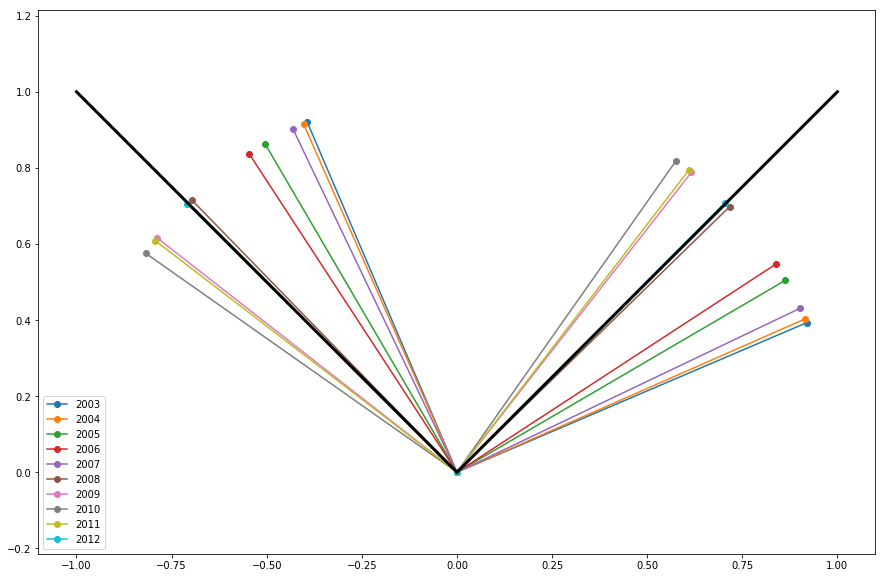

In [23]:
plt.figure(figsize=(15,10))
for i,y in enumerate(range(2003,2013)):
    w,v = lambdas(y)
    plt.plot([0,v[0,0]],[0,v[1,0]],'o-',color=plt.rcParams['axes.prop_cycle'].by_key()['color'][i%10],label=str(y))
    plt.plot([0,v[0,1]],[0,v[1,1]],'o-',color=plt.rcParams['axes.prop_cycle'].by_key()['color'][i%10])
    plt.legend()
    plt.grid()
plt.plot([0,1],[0,1],'k',lw=3)
plt.plot([0,-1],[0,1],'k',lw=3)
# plt.xlim(0,1.3)
# plt.ylim(0,1.3)
plt.axis('equal')

In [24]:
# aszimmetria a kuldesben es a fogadasban?

In [25]:
res.value = res.value.map(float)
res[(res["model_part"]=="model_w_ij")]

,model_part,variable,value,std_error,significance,year
0,model_w_ij,log_d_ij,-1.05100,0.05260,3.0,2002
1,model_w_ij,log_P_i,-4.25600,0.98200,3.0,2002
2,model_w_ij,log_P_j,-0.77800,0.89700,0.0,2002
3,model_w_ij,log_P_i_2,0.21000,0.02310,3.0,2002
4,model_w_ij,log_P_j_2,0.06490,0.01870,3.0,2002
5,model_w_ij,log_P_i_log_P_j,0.06000,0.04140,0.0,2002
6,model_w_ij,_cons,15.55000,10.94000,0.0,2002
0,model_w_ij,log_d_ij,-0.88200,0.03900,3.0,2003
1,model_w_ij,log_P_i,-4.20500,0.47000,3.0,2003
2,model_w_ij,log_P_j,-1.60200,0.51900,3.0,2003


### coefficients in the quadratic form

In [26]:
res[(res["model_part"]=="model_w_ij")].pivot_table(index="year",columns="variable",values="value")

variable,_cons,log_P_i,log_P_i_2,log_P_i_log_P_j,log_P_j,log_P_j_2,log_d_ij
year,,,,,,,
2002,15.550,-4.25600,0.21000,0.0600,-0.7780,0.0649,-1.051
2003,22.220,-4.20500,0.17600,0.1150,-1.6020,0.0661,-0.882
2004,17.810,-3.57500,0.14500,0.1130,-1.1430,0.0416,-0.787
2005,9.638,-2.17800,0.09550,0.1040,-0.8820,0.0369,-0.918
2006,-1.285,-0.53200,0.05060,0.0625,-0.0645,0.0231,-1.389
2007,-2.620,-0.29000,0.04590,0.0416,0.3100,0.0123,-1.605
2008,-1.812,0.00134,0.03100,0.0340,-0.0960,0.0301,-1.566
2009,-1.763,0.08040,0.02220,0.0386,-0.2230,0.0318,-1.476
2010,-2.677,0.21300,0.01450,0.0362,-0.1440,0.0275,-1.442


### eigvals and eccentricity

In [27]:
eigvals = pd.DataFrame([lambdas(y)[0] for y in range(2002,2013)],columns=["lambda1","lambda2"],index=range(2002,2013))
eigvals['ecc'] = np.sqrt(1-eigvals['lambda2']/eigvals['lambda1'])
eigvals

,lambda1,lambda2,ecc
2002,0.215958,0.058942,0.852682
2003,0.200585,0.041515,0.890521
2004,0.169884,0.016716,0.949529
2005,0.125887,0.006513,0.973786
2006,0.070991,0.002709,0.980736
2007,0.055837,0.002363,0.978614
2008,0.047556,0.013544,0.845694
2009,0.046888,0.007112,0.921042
2010,0.040232,0.001768,0.977777
2011,0.043006,-0.034426,1.341825


### quadratic surfaces and sections

$$\log w \sim \alpha \log P_i^2 + \beta \log P_i \log P_j + \gamma \log P_j^2 + \delta \log P_i +\varepsilon \log P_j + \chi \log d + C$$

$$\frac{\log w}{\log P_i} = 2\alpha \log P_i + \beta \log P_j + \delta$$
$$\frac{\log w}{\log P_j} = 2\gamma \log P_j + \beta \log P_i + \varepsilon$$

In [30]:
# cimkezni a 2-4. y-tengelyt
# ha egyenes szintvonalak lennenek -> hatvanyfuggveny
# ha paraboloid -> a nagyobb telepulesek dominaljak a kuldest
# ha paraboloid -> nehezen kuldenek a sajatjuktol eltero meretre a telepulesek
# a nagytelepulesek a targetek
# ha hiperboloid -> a kisebb telepulesek dominaljak a kuldest, ok fognak le nagy meretskalat!
# a kistelepulesek a targetek
# ha hiperboloid -> a sajatjuktol eltero merettartomanyban "konnyebb" kuldeni

# akkor a kistelepulesek a laggardok
# viselkedesuk a kesobbi idoszakban dominal

In [28]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['font.size'] = 20

In [38]:
import seaborn as sns

In [68]:
gamma_value = res[(res["model_part"]=="model_w_ij")].pivot_table(index="year",columns="variable",values="value")["log_d_ij"]
gamma_err = res[(res["model_part"]=="model_w_ij")].pivot_table(index="year",columns="variable",values="std_error")["log_d_ij"]

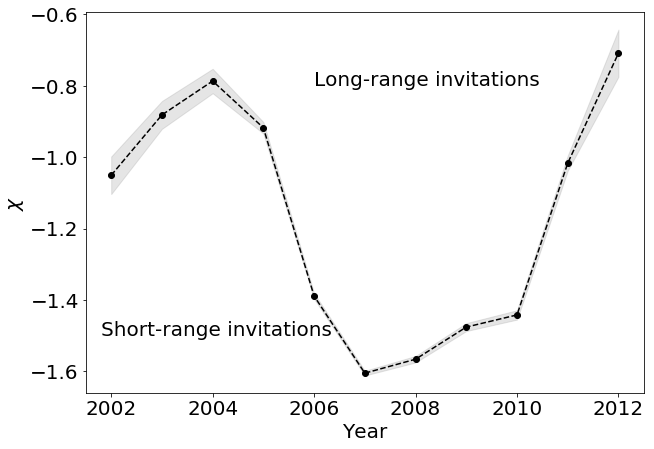

In [73]:
plt.figure(figsize=(10,7))
plt.plot(gamma_value,'ko--')
plt.fill_between(gamma_err.index,gamma_value-gamma_err,gamma_value+gamma_err,alpha=0.2,color='grey')
plt.xticks(range(2002,2013,2))
plt.xlabel('Year')
plt.ylabel(r'$\chi$')
plt.annotate('Short-range invitations',(2001.8,-1.5))
plt.annotate('Long-range invitations',(2006,-0.8))
plt.savefig('regdist.png',density=300,bbox_inches='tight')

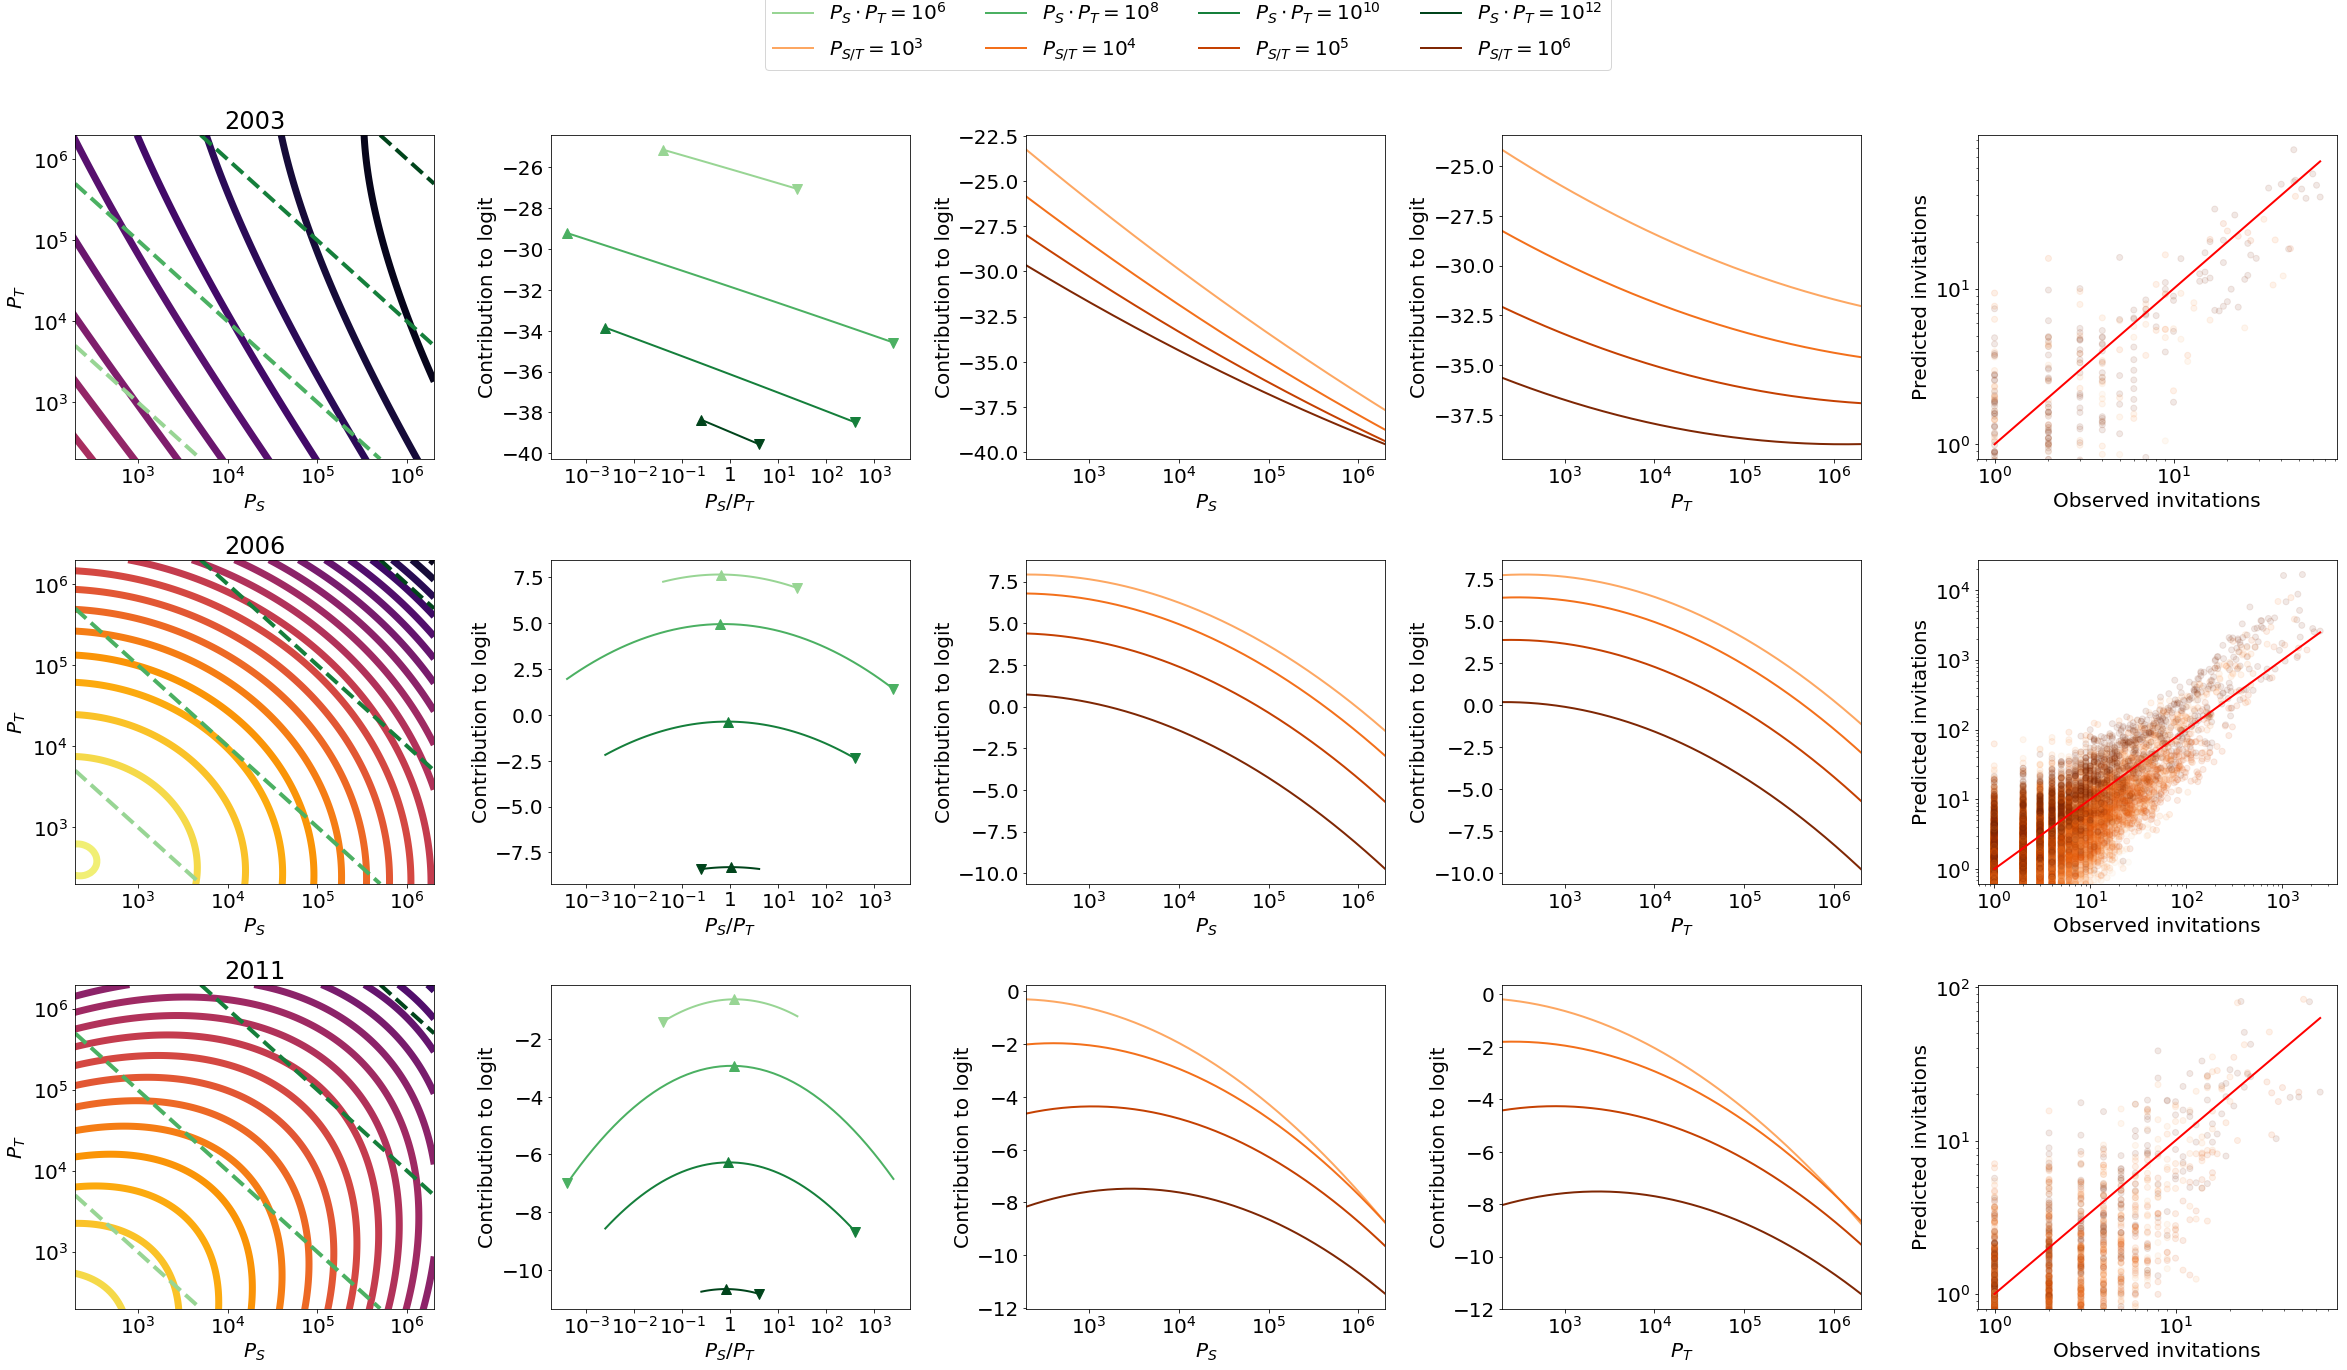

In [74]:
# 5-panel figure for each year

years = [2003,2006,2011]

fig,ax = plt.subplots(len(years),5,figsize=(33,6*len(years)))

for k,year in enumerate(years):
    params = res[(res["model_part"]=="model_inflate")].pivot_table(index="year",columns="variable",values="value").loc[year]
    x = np.linspace(0,np.log(2e6),200)
    y = np.linspace(0,np.log(2e6),200)
    X,Y = np.meshgrid(x,y)
    
    def f(a,b):
        Z = params["log_P_i_2"]*a**2 + params["log_P_j_2"]*b**2 + params["log_P_i_log_P_j"]*a*b+params["log_P_i"]*a+params["log_P_j"]*b
        return Z
    
    # size of Budapest
    bp = np.log(2e6)
    # size of a small village
    v = np.log(200) 
    

    
    # colors for different sections
    diag_colors = plt.cm.Greens(np.linspace(0.4,1,4))
    hcolors = plt.cm.Oranges(np.linspace(0.4,1,4))
    vcolors = plt.cm.Purples(np.linspace(0.4,1,4))
    
    for i,c in enumerate([np.log(10**k) for k in [6,8,10,12]]):
        # diagonal cuts
        tx = np.linspace(np.max([v,c-bp]),np.min([bp,c-v]))
        ty = c-tx
        
        ax[k,0].plot(tx,ty,'--',color=diag_colors[i], lw=4)
        
        # plotting cut values to next axis
        ax[k,1].plot(tx-ty,f(tx,ty),label=r'$P_S\cdot P_T=10^{%.0f}$' % np.log10(np.exp(c)),color=diag_colors[i], lw=2)
        yamin = np.argmin(f(tx,ty))
        ax[k,1].plot(tx[yamin]-ty[yamin],f(tx,ty)[yamin],'v',markersize=10,color=diag_colors[i], lw=2)
        yamax = np.argmax(f(tx,ty))
        ax[k,1].plot(tx[yamax]-ty[yamax],f(tx,ty)[yamax],'^',markersize=10,color=diag_colors[i], lw=2)

        # horizontal cuts
        tx = np.linspace(v,bp,200)
        ty = np.linspace(c/2,c/2,200)
        
        ax[k,2].plot(tx,f(tx,ty),label=r'$P_{S/T}=10^{%.0f}$' % np.log10(np.exp(c/2)),color=hcolors[i], lw=2)

            
        # vertical cuts
        ax[k,3].plot(tx,f(ty,tx),label=r'$P_S=10^{%.0f}$' % np.log10(np.exp(c/2)),color=hcolors[i], lw=2)

            
#     ax[k,1].set_ylim(-25,20)
    ax[k,1].set_xlabel(r"$P_S/P_T$")
    mul = np.array([1,2,3]) 
    ax[k,1].set_xticks(list(np.log(1/10**mul)[::-1])+[0]+list(np.log(10**mul)))
    ax[k,1].set_xticklabels([r'$10^{-'+str(m)+'}$' for m in mul[::-1]]+['1']+[f'$10^{m}$' for m in mul])
    ax[k,1].set_ylabel(r'Contribution to logit')
    
    ax[k,2].set_xlim(v,bp)
    ax[k,2].set_xlabel(r"$P_S$")
    ax[k,2].set_ylabel(r'Contribution to logit')
    
    ax[k,3].set_xlim(v,bp)
    ax[k,3].set_xlabel(r"$P_T$")
    ax[k,3].set_ylabel(r'Contribution to logit')
    
    ax[k,0].set_xlabel(r"$P_S$")
    ax[k,0].set_ylabel(r"$P_T$")
    
    # plotting the function itself
    ax[k,0].contour(X,Y,f(X,Y),cmap='inferno',linewidths=7, levels=20)
    ax[k,0].set_title(str(year))
    ax[k,0].set_ylim(v,bp)
    ax[k,0].set_xlim(v,bp)
    
    for a in [0,2,3]:
        ax[k,a].set_xticks([np.log(np.power(10,x)) for x in range(3,7)])
        ax[k,a].set_xticklabels([f'$10^{x}$' for x in range(3,7)])
    
    ax[k,0].set_yticks([np.log(np.power(10,x)) for x in range(3,7)])
    ax[k,0].set_yticklabels([f'$10^{x}$' for x in range(3,7)])
    
    dp = subset_edgelist(year, nonzero=True)
    params_count = res[(res["model_part"]=="model_w_ij")].pivot_table(index="year",columns="variable",values="value").loc[year]
    params_inf = res[(res["model_part"]=="model_inflate")].pivot_table(index="year",columns="variable",values="value").loc[year]
    
    def cnt_pred(x,y,z):
        tc = params_count["log_P_i_2"]*x**2 + params_count["log_P_j_2"]*y**2 + params_count["log_P_i_log_P_j"]*x*y+params_count["log_P_i"]*x+params_count["log_P_j"]*y+params_count["log_d_ij"]*z+params_count["_cons"]
        ti = params_inf["log_P_i_2"]*x**2 + params_inf["log_P_j_2"]*y**2 + params_inf["log_P_i_log_P_j"]*x*y+params_inf["log_P_i"]*x+params_inf["log_P_j"]*y+params_inf["log_d_ij"]*z+params_inf["_cons"]
        p0 = np.exp(ti)/(1+np.exp(ti))
        return np.exp(tc)*(1-p0)
  
                      
    mask = (dp["log_P_i"]>v)
    ax[k,4].scatter(dp[mask]["w_ij"],cnt_pred(dp[mask]["log_P_i"],dp[mask]["log_P_j"],dp[mask]["log_d_ij"]),c=dp[mask]["log_P_i"],cmap='Oranges',alpha=0.1)
    ax[k,4].plot([1,dp[mask]["w_ij"].max()],[1,dp[mask]["w_ij"].max()],'r-',lw=2)
    ax[k,4].set_xlabel("Observed invitations")
    ax[k,4].set_ylabel("Predicted invitations")
    ax[k,4].loglog()

#     dp["log_P_i_bin"] = dp["log_P_i"].map(int)
#     dp["log_w_ij_pred"] = np.log(cnt_pred(dp["log_P_i"],dp["log_P_j"],dp["log_d_ij"]))
#     dp["log_w_ij_obs"] = np.log(dp["w_ij"])
    
#     dp["diff"] = dp["log_w_ij_pred"] - dp["log_w_ij_obs"]
#     sns.boxplot(data=dp,x="log_P_i_bin",y="diff",ax=ax[k,4])
    
    

h1,l1 = ax[0,1].get_legend_handles_labels()
h2,l2 = ax[0,2].get_legend_handles_labels()

h = []
l = []

for i in range(len(h1)):
    h.append(h1[i])
    h.append(h2[i])
    l.append(l1[i])
    l.append(l2[i])

fig.legend(h,l, loc="lower center", bbox_to_anchor = (0.5,0.995),ncol=4)
plt.subplots_adjust(hspace=0.3)
plt.tight_layout()
plt.show()

$$w = e^{a_1}\cdot(1-\frac{e^{a_2}}{1+e^{a_2}})$$

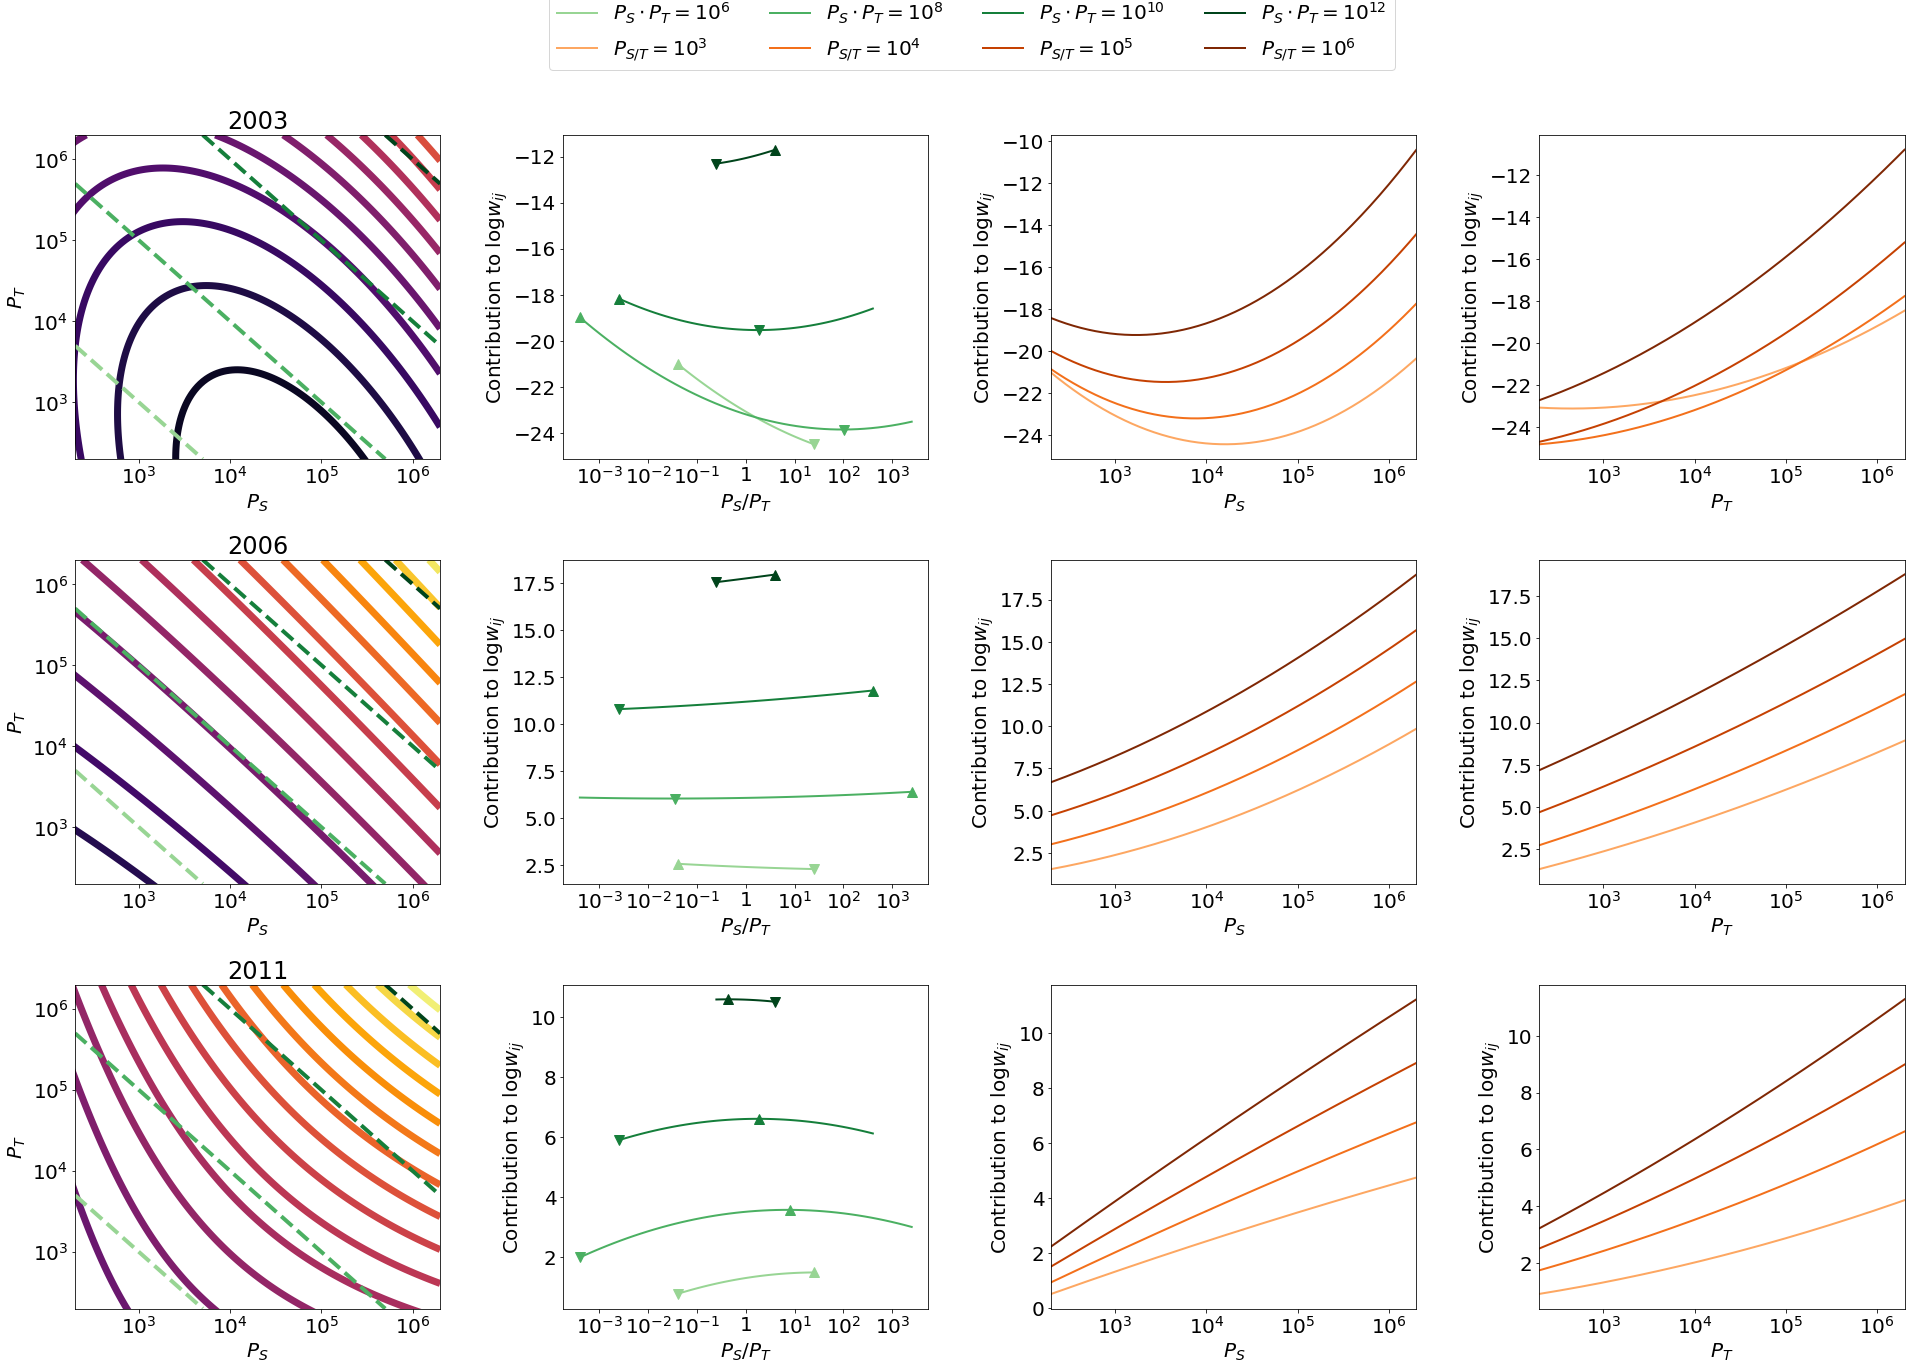

In [79]:
# 5-panel figure for each year

years = [2003,2006,2011]

fig,ax = plt.subplots(len(years),4,figsize=(27,6*len(years)))

for k,year in enumerate(years):
    params = res[(res["model_part"]=="model_w_ij")].pivot_table(index="year",columns="variable",values="value").loc[year]
    x = np.linspace(0,np.log(2e6),200)
    y = np.linspace(0,np.log(2e6),200)
    X,Y = np.meshgrid(x,y)
    
    def f(a,b):
        Z = params["log_P_i_2"]*a**2 + params["log_P_j_2"]*b**2 + params["log_P_i_log_P_j"]*a*b+params["log_P_i"]*a+params["log_P_j"]*b
        return Z
    
    # size of Budapest
    bp = np.log(2e6)
    # size of a small village
    v = np.log(200) 
    

    
    # colors for different sections
    diag_colors = plt.cm.Greens(np.linspace(0.4,1,4))
    hcolors = plt.cm.Oranges(np.linspace(0.4,1,4))
    vcolors = plt.cm.Purples(np.linspace(0.4,1,4))
    
    for i,c in enumerate([np.log(10**k) for k in [6,8,10,12]]):
        # diagonal cuts
        tx = np.linspace(np.max([v,c-bp]),np.min([bp,c-v]))
        ty = c-tx
        
        ax[k,0].plot(tx,ty,'--',color=diag_colors[i], lw=4)
        
        # plotting cut values to next axis
        ax[k,1].plot(tx-ty,f(tx,ty),label=r'$P_S\cdot P_T=10^{%.0f}$' % np.log10(np.exp(c)),color=diag_colors[i], lw=2)
        yamin = np.argmin(f(tx,ty))
        ax[k,1].plot(tx[yamin]-ty[yamin],f(tx,ty)[yamin],'v',markersize=10,color=diag_colors[i], lw=2)
        yamax = np.argmax(f(tx,ty))
        ax[k,1].plot(tx[yamax]-ty[yamax],f(tx,ty)[yamax],'^',markersize=10,color=diag_colors[i], lw=2)

        # horizontal cuts
        tx = np.linspace(v,bp,200)
        ty = np.linspace(c/2,c/2,200)
        
        ax[k,2].plot(tx,f(tx,ty),label=r'$P_{S/T}=10^{%.0f}$' % np.log10(np.exp(c/2)),color=hcolors[i], lw=2)

            
        # vertical cuts
        ax[k,3].plot(tx,f(ty,tx),label=r'$P_S=10^{%.0f}$' % np.log10(np.exp(c/2)),color=hcolors[i], lw=2)

            
#     ax[k,1].set_ylim(-25,20)
    ax[k,1].set_xlabel(r"$P_S/P_T$")
    mul = np.array([1,2,3]) 
    ax[k,1].set_xticks(list(np.log(1/10**mul)[::-1])+[0]+list(np.log(10**mul)))
    ax[k,1].set_xticklabels([r'$10^{-'+str(m)+'}$' for m in mul[::-1]]+['1']+[f'$10^{m}$' for m in mul])
    ax[k,1].set_ylabel(r'Contribution to $\log w_{ij}$')
    
    ax[k,2].set_xlim(v,bp)
    ax[k,2].set_xlabel(r"$P_S$")
    ax[k,2].set_ylabel(r'Contribution to $\log w_{ij}$')
    
    ax[k,3].set_xlim(v,bp)
    ax[k,3].set_xlabel(r"$P_T$")
    ax[k,3].set_ylabel(r'Contribution to $\log w_{ij}$')
    
    ax[k,0].set_xlabel(r"$P_S$")
    ax[k,0].set_ylabel(r"$P_T$")
    
    # plotting the function itself
    ax[k,0].contour(X,Y,f(X,Y),cmap='inferno',linewidths=7, levels=20)
    ax[k,0].set_title(str(year))
    ax[k,0].set_ylim(v,bp)
    ax[k,0].set_xlim(v,bp)
    
    for a in [0,2,3]:
        ax[k,a].set_xticks([np.log(np.power(10,x)) for x in range(3,7)])
        ax[k,a].set_xticklabels([f'$10^{x}$' for x in range(3,7)])
    
    ax[k,0].set_yticks([np.log(np.power(10,x)) for x in range(3,7)])
    ax[k,0].set_yticklabels([f'$10^{x}$' for x in range(3,7)])
    
    dp = subset_edgelist(year, nonzero=True)
    params_count = res[(res["model_part"]=="model_w_ij")].pivot_table(index="year",columns="variable",values="value").loc[year]
    params_inf = res[(res["model_part"]=="model_inflate")].pivot_table(index="year",columns="variable",values="value").loc[year]
    
    def cnt_pred(x,y,z):
        tc = params_count["log_P_i_2"]*x**2 + params_count["log_P_j_2"]*y**2 + params_count["log_P_i_log_P_j"]*x*y+params_count["log_P_i"]*x+params_count["log_P_j"]*y+params_count["log_d_ij"]*z+params_count["_cons"]
        ti = params_inf["log_P_i_2"]*x**2 + params_inf["log_P_j_2"]*y**2 + params_inf["log_P_i_log_P_j"]*x*y+params_inf["log_P_i"]*x+params_inf["log_P_j"]*y+params_inf["log_d_ij"]*z+params_inf["_cons"]
        p0 = np.exp(ti)/(1+np.exp(ti))
        return np.exp(tc)*(1-p0)
  
                      
#     mask = (dp["log_P_i"]>v)
# #     ax[k,4].scatter(dp[mask]["w_ij"],cnt_pred(dp[mask]["log_P_i"],dp[mask]["log_P_j"],dp[mask]["log_d_ij"]),c=dp[mask]["log_P_i"],cmap='Oranges',alpha=0.1)
#     ax[k,4].scatter(dp[mask]["w_ij"],cnt_pred(dp[mask]["log_P_i"],dp[mask]["log_P_j"],dp[mask]["log_d_ij"]),c='black',cmap='Oranges',alpha=0.1)
#     ax[k,4].plot([1,dp[mask]["w_ij"].max()],[1,dp[mask]["w_ij"].max()],'k--',lw=2)
#     ax[k,4].set_xlabel("Observed invitations")
#     ax[k,4].set_ylabel("Predicted invitations")
#     ax[k,4].loglog()

#     dp["log_P_i_bin"] = dp["log_P_i"].map(int)
#     dp["log_w_ij_pred"] = np.log(cnt_pred(dp["log_P_i"],dp["log_P_j"],dp["log_d_ij"]))
#     dp["log_w_ij_obs"] = np.log(dp["w_ij"])
    
#     dp["diff"] = dp["log_w_ij_pred"] - dp["log_w_ij_obs"]
#     sns.boxplot(data=dp,x="log_P_i_bin",y="diff",ax=ax[k,4])
    
    

h1,l1 = ax[0,1].get_legend_handles_labels()
h2,l2 = ax[0,2].get_legend_handles_labels()

h = []
l = []

for i in range(len(h1)):
    h.append(h1[i])
    h.append(h2[i])
    l.append(l1[i])
    l.append(l2[i])

fig.legend(h,l, loc="lower center", bbox_to_anchor = (0.5,0.995),ncol=4)
plt.subplots_adjust(hspace=0.3)
plt.tight_layout()
plt.savefig('regression.png',density=300,bbox_inches='tight')
plt.show()